## Image generation example

In [86]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

%matplotlib inline

In [87]:
# Set up plotting data

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])
print(inputs.shape)

(100, 100, 2)


In [88]:
# Helper function to compute transformed distribution densities

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [89]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

In [90]:
def transform_distribution(distribution, alpha, theta):
    # treat alpha as a scale factor
    bijector = tfb.Scale(alpha)
    
    return tfd.TransformedDistribution(
        distribution,
        bijector
    )

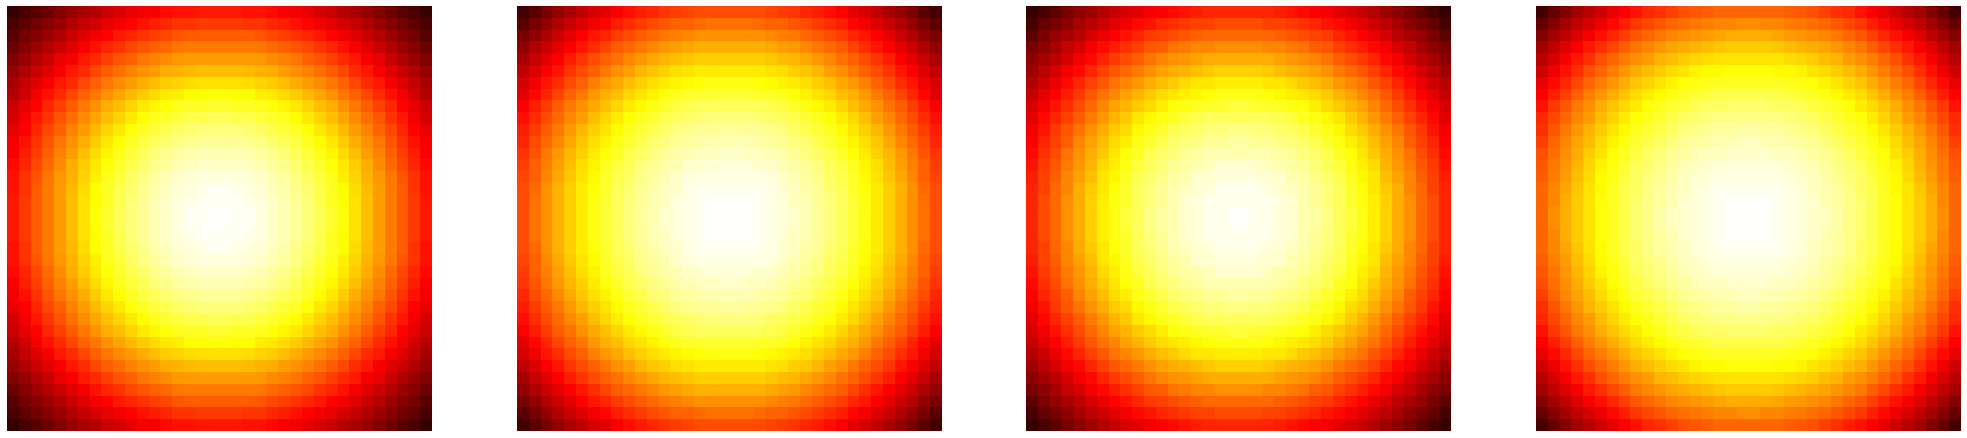

In [91]:
from IPython.display import Image, display

base_distribution = tfd.MultivariateNormalDiag(loc=[[0,0]], scale_diag=[[0.3,0.3]])

theta_distribution = tfd.Uniform(low=0.0, high=2*math.pi)
alpha_distribution = tfd.Normal(loc=0.0, scale=3.0)

fig, ax = plt.subplots(1, 4, figsize=(35, 35))

for i in range(4):
    alpha = alpha_distribution.sample()
    theta = theta_distribution.sample()
    transformed_distribution = transform_distribution(base_distribution, alpha, theta)
    
    densities = get_densities(transformed_distribution)
    density = densities[0]

    image = get_image_array_from_density_values(density)

    ax[i].imshow(image)
    ax[i].axis("off")
    
plt.show()

In [92]:
# Build the dataset
dataset = []
num_images = 33

for i in range(num_images):
    alpha = alpha_distribution.sample()
    theta = theta_distribution.sample()
    transformed_distribution = transform_distribution(base_distribution, alpha, theta)
    
    densities = get_densities(transformed_distribution)
    density = densities[0]

    image = get_image_array_from_density_values(density)
    
    dataset.append(image)

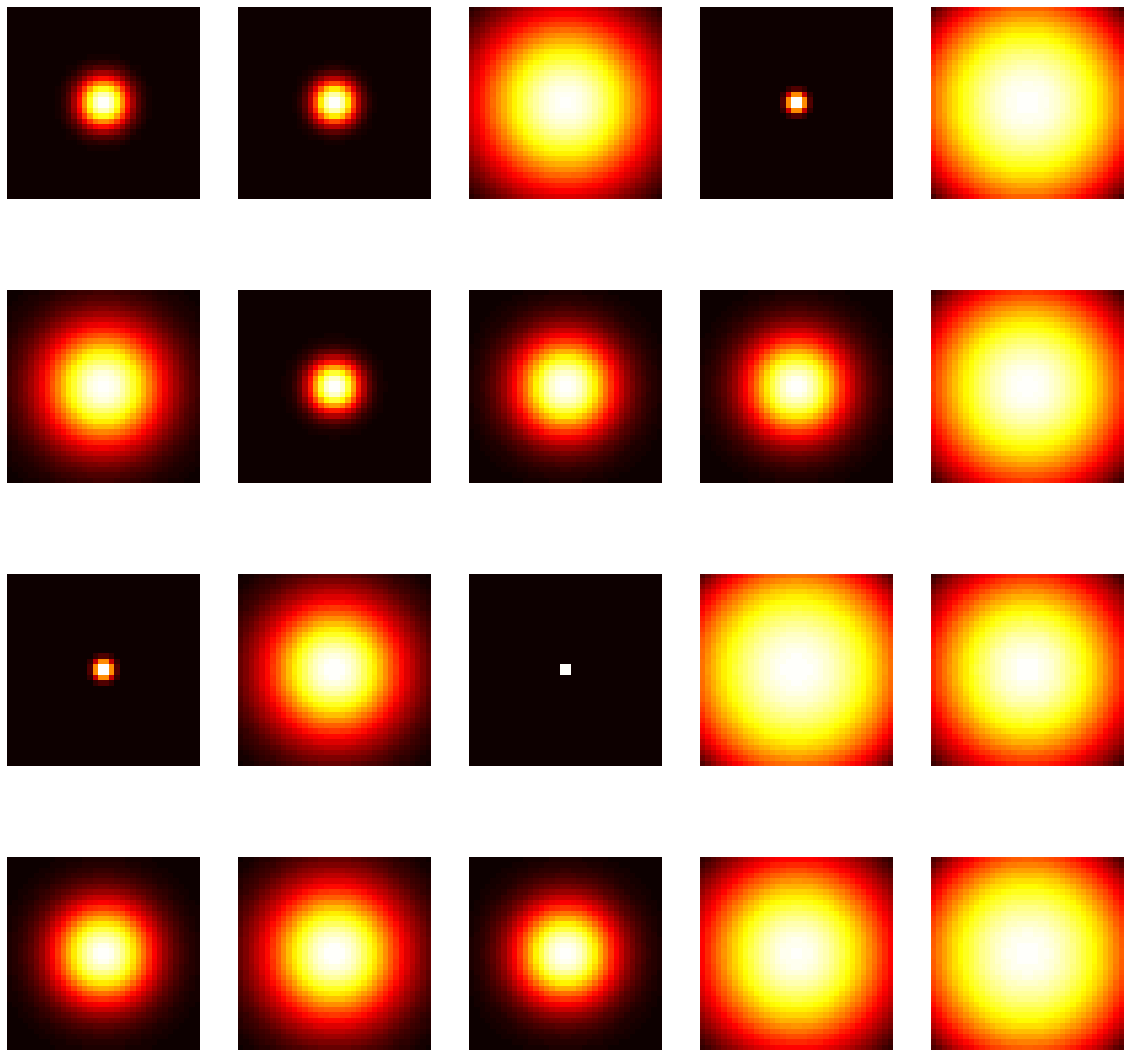

In [93]:
# Display a sample of 20 images from your generated dataset in a figure

from numpy.random import default_rng
rng = default_rng()

fig, axs = plt.subplots(4, 5, figsize=(20, 20))

for k in range(20):
    i = k // 5
    j = k % 5
    
    index = rng.integers(low=0, high=num_images)
    axs[i, j].imshow(dataset[index])
    axs[i, j].axis('off')
    
plt.show()